### Data Visualization - Ideal vs Encountered

In [24]:
#user-defined
import ipynb.fs.full.helper as hp

#dataframes
import pandas as pd
import h5py


#suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#math
import numpy as np
import math as m

from scipy.spatial.distance import cdist
pd.TimeSeries = pd.Series 

#plots
import pylab as plt
import matplotlib.pyplot as plt
import matplotlib.animation as animation

#performance
import time 
import multiprocessing as mp

### Load Data

In [25]:
set_number = 5

dir = '~/dataAnalysis/Sprints/Run03/Set0'+str(set_number)+'/'
dir_save = '/home/ecc/dataAnalysis/Images/'

wind_load= 'wind0'+str(set_number)+'Run03_Expected_Full.hdf'
wind_load_small = 'wind0'+str(set_number)+'Run03_Expected_Small.hdf' ## bag saved from datavisoptimization 
                                                               ## with expected odor information

windn = pd.read_hdf(dir+wind_load)
windsm = pd.read_hdf(dir+wind_load_small)

### Prepare Data

In [26]:
df = pd.DataFrame()
df = windsm
dt= df.master_time[1]-df.master_time[0]

In [5]:
# storing the odor location in a numpy array to avoid reading pandas
odor_position = np.array([[df.xsrc[i],df.ysrc[i]] for i in range (len(df.xsrc))]) 

In [17]:
#summation till Nth particle
eastwest = [np.sum(df.U[j:])*dt for j in range(0,len(df))]
northsouth = [np.sum(df.V[j:])*dt for j in range(0,len(df))]

### Imagewise Animation Odor_expected vs Odor_encountered (from sensor)

In [18]:

count = 0
N=2500

#for(upper, lower, step)
#avoiding the last particle
for i in range((len(eastwest))-1,0, -1):   
    fig = plt.figure()
    fig.suptitle('Radius time**0.5*0.01 - Run03_Set05_Small', fontsize =14)
    
    ax = plt.axes (xlim=(-8,15), ylim=(-2,30))
    ax.set_xlabel('Longitude (meters)')
    ax.set_ylabel('Latitude(meters)')
    
    #TODO: Ignoring 0th point
    
    eastwest = np.resize(np.array([eastwest-df.U[i]*dt]),(1,i)).flatten() 
    northsouth = np.resize(np.array([northsouth-df.V[i]*dt]),(1,i)).flatten()

    area = np.arange(start = i, stop = 0, step = -1)**2*0.04*m.pi #area
    
    ax.scatter(eastwest, northsouth, c='#FFA500', alpha = 0.3, s=(area/4))
    
    if (count<2499):          
        ax.scatter(df.xsrc[N:i],df.ysrc[N:i], c = df.odor[N:i], cmap = 'inferno', vmin =0 , vmax = 13, s =12)
        N=N-1
        
    else:
        ax.scatter(df.xsrc[:i],df.ysrc[:i], c = df.odor[:i],cmap = 'inferno', vmin =0 , vmax = 13, s =12 )

    count+=1
    
    fig.savefig(dir_save + "plot" + str(i) + ".jpg")
    plt.close()
        

### Imagewise Animation Odor_Expected vs Time

In [27]:
def plot_ts(input):
    i, df = input
    fig = plt.figure()
    ax = plt.axes (xlim=(0,300), ylim=(0,2))
    ax.set_xlabel('Time')
    ax.set_ylabel('Odor Concentration')
    ax.plot(df.sync_time[:i],df.odor_expected[:i])
    fig.savefig(dir_save + "plot" + str(i) + ".jpg")
    plt.close()

In [ ]:
start = time.time()

inputs = [[i, df] for i in range(len(df))]
pool = mp.Pool(processes=(mp.cpu_count()-1))
pool.map(plot_ts, inputs)
pool.terminate()

time.time()-start

In [17]:
# start = time.time()
# for i in range(0,300):
#     fig = plt.figure()
#     #fig.suptitle('Odor Encounters')
#     ax = plt.axes (xlim=(0,300), ylim=(0,2))
#     ax.set_xlabel('Time')
#     ax.set_ylabel('Odor Concentration')


#     ax.plot(df.sync_time[:i],df.odor_expected[:i])
#     fig.savefig(dir_save + "plot" + str(i) + ".jpg")
#     plt.close()
    
# time.time()-start

15.51100778579712

NOTE: ANYTHING BELOW IS JUST FOR PERSONAL NOTE PURPOSE 

### Animation using Matplotlib Animation

In [40]:
# fig = plt.figure()
# ax = plt.axes(xlim=(-22,2), ylim=(-15,30))
# ax.set_xlabel('Eastwest (meters)')
# ax.set_ylabel('NorthSouth (meters)')
# plt.close()
# line, = ax.scatter([],[], 'o', lw=2)

# def init():
#     line.set_data([],[])
#     return line,

# # def get_data_x(i):
# #     return we.loc[i]

# def get_data_y(i):
#     return generate_particle(i)

# def update(i):
#     #x = get_data_x(i)
#     y = get_data_y(i)
#     line.set_data(y)
#     return line,

# #an = animation.FuncAnimation(fig,update,frames = pd.Index.intersection(we.index,ns.index),
#                               #interval = 5, blit=False)
# #an.save('../../../Research/Images/Video/fast_flow.mp4', fps=100, extra_args=['-vcodec', 'libx264'])
# # plt.show()

#### 2D scatter plot for entire 300 seconds for ideal vs actual odor counters

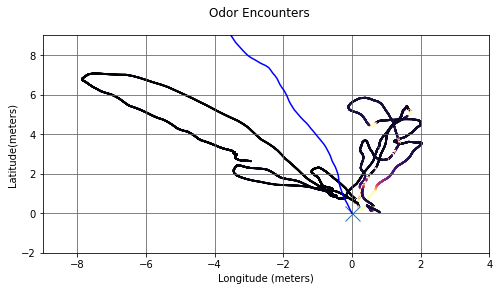

In [57]:
fig, ax = plt.subplots(1, figsize=(8, 4))
fig.suptitle('Odor Encounters')
ax = plt.axes (xlim=(-9,4), ylim=(-2,9))
# Plot the data
ax.scatter(geodfsub.xsrc, geodfsub.ysrc, c=geodfsub.odor, cmap='magma', s= 0.8)
ax.set_xlabel('Longitude (meters)')
ax.set_ylabel('Latitude(meters)')
plt.plot(0,0, marker='x', markersize=15)
# Show the grid lines as dark grey lines
ax.grid(b=True, which='major', color='#666666', linestyle='-')
plt.plot(we.particle0,ns.particle0, c='b')


#### 2D scatter plot for high odor concentration vs ideal wind particle

(-16.0, 3.0)

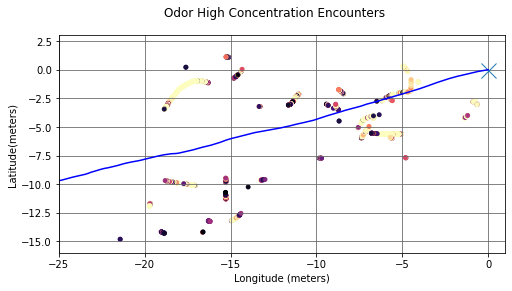

In [13]:
fig, ax = plt.subplots(1, figsize=(8, 4))
fig.suptitle('Odor High Concentration Encounters')
ax = plt.axes (xlim=(-9,4), ylim=(-2,9))
# Plot the data
ax.scatter(df_t.xsrc, df_t.ysrc, c=df_t.odor, cmap='magma', s= 15)
ax.set_xlabel('Longitude (meters)')
ax.set_ylabel('Latitude(meters)')
plt.plot(0,0, marker='x', markersize=15)
# Show the grid lines as dark grey lines
ax.grid(b=True, which='major', color='#666666', linestyle='-')
plt.plot(we.particle0,ns.particle0, markersize=20, c='b')


#### ANIMATION 02 - Ideal vs Encountered Odor

In [ ]:
## Setting figure

fig = plt.figure()
ax = plt.axes(xlim=(-9,4), ylim=(-2,9))
ax.set_xlabel('Eastwest (meters)')
ax.set_ylabel('NorthSouth (meters)')
plt.close()

wind, = ax.plot([],[], 'o', color ="b", lw = 2)
line, = ax.scatter([],[], c = geodfsub.odor, cmap='magma', s= 15)

def init():
    line.set_data([],[])  
    wind.set_data([],[])
    return wind,

def get_data_we_(i):
    return dfwe.loc[i]

def get_data_ns_(i):
    return dfns.loc[i]

def get_data_x_(i):
    return geodfsub.xsrc[i]

def get_data_y_(i):
    return geodfsub.ysrc[i]

def update(i):
#     wex = get_data_we_(i)
#     nsy = get_data_ns_(i)
#     wind.set_data(wex,nsy)
    x = get_data_x_(i)
    y = get_data_y_(i)
    line.set_data(x,y)
    
    return line,




In [19]:
# ani = animation.FuncAnimation(fig, update, init_func=init, frames = int(len(geodfsub.ysrc)/2), interval = 5, blit=False)
ani = animation.FuncAnimation(fig, update, init_func=init, frames = 500, interval = 5, blit=False)


#ani.save('../../../Research/Images/Video/test_ideal.mp4', fps=100, extra_args=['-vcodec', 'libx264'])
#HTML(ani.to_html5_video())


